# Data

In [71]:
import pandas as pd

import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import time

In [72]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
                 sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [73]:
# cols_2_plot = df.columns.drop('residual sugar')

/tmp/ipython-input-2444677833.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


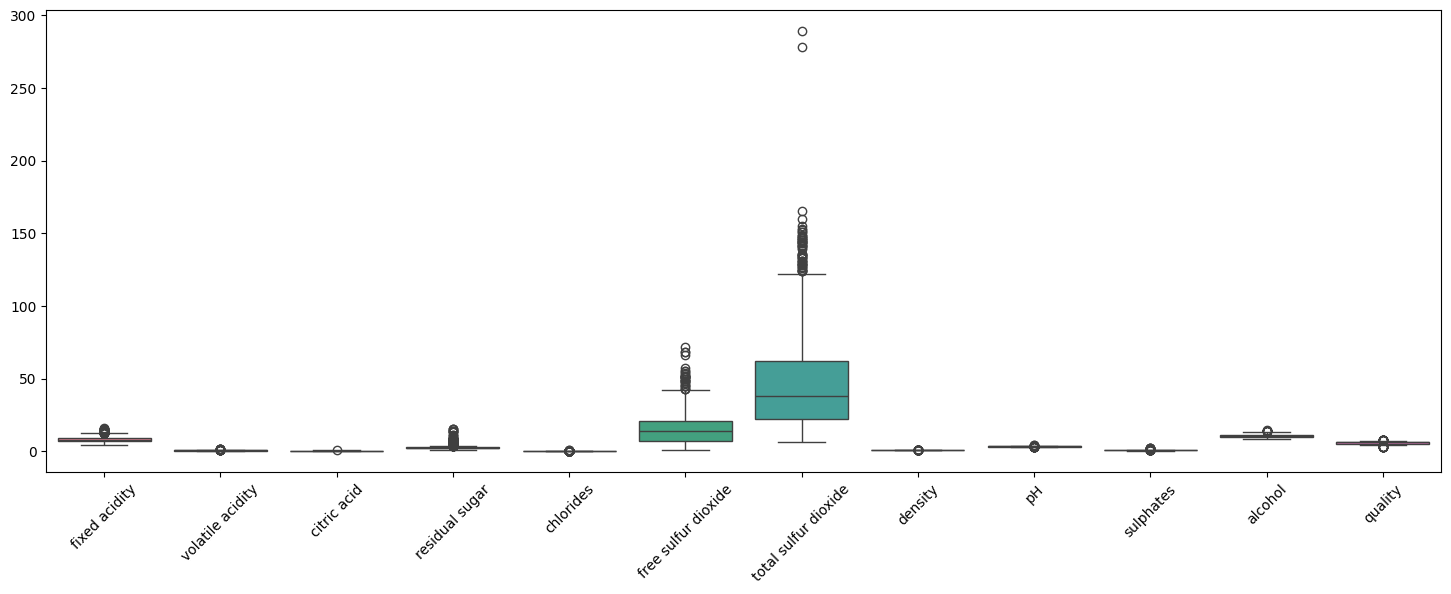

In [74]:
fig, ax = plt.subplots(1, figsize = (18, 6))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

Getting rid of outliers

/tmp/ipython-input-4099080576.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


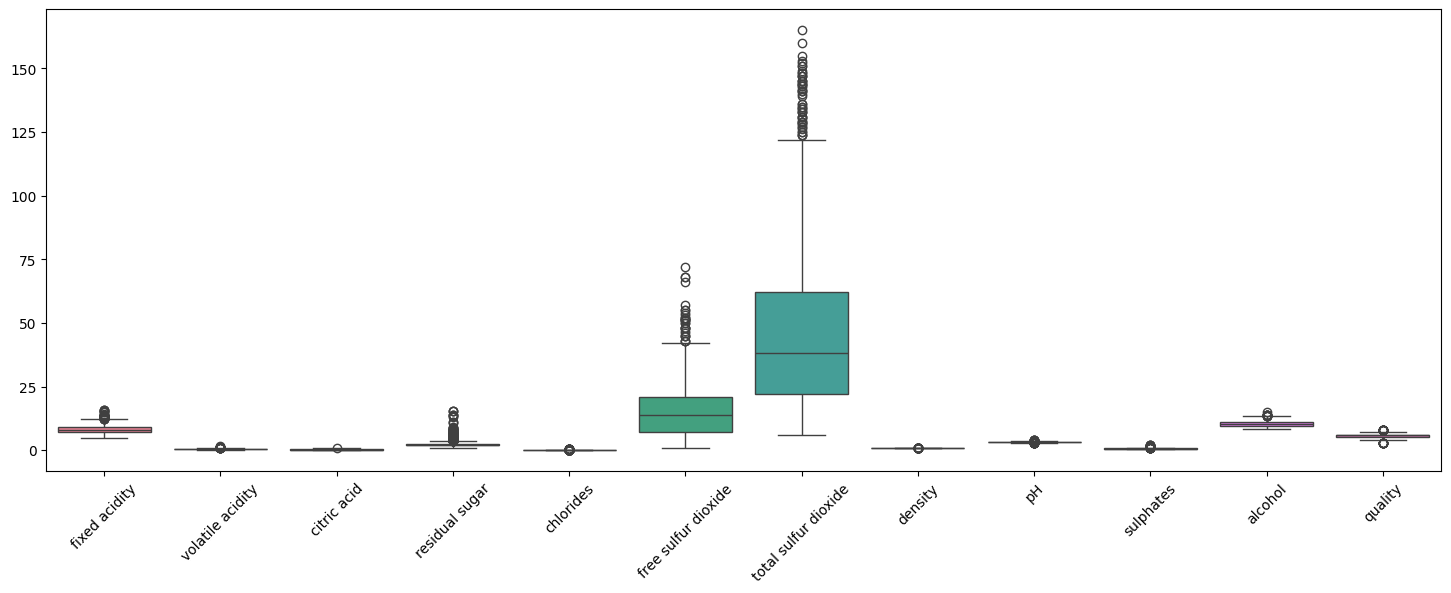

In [75]:
df = df[df['total sulfur dioxide'] < 200]

fig, ax = plt.subplots(1, figsize = (18, 6))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

Z-score

/tmp/ipython-input-3518540947.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


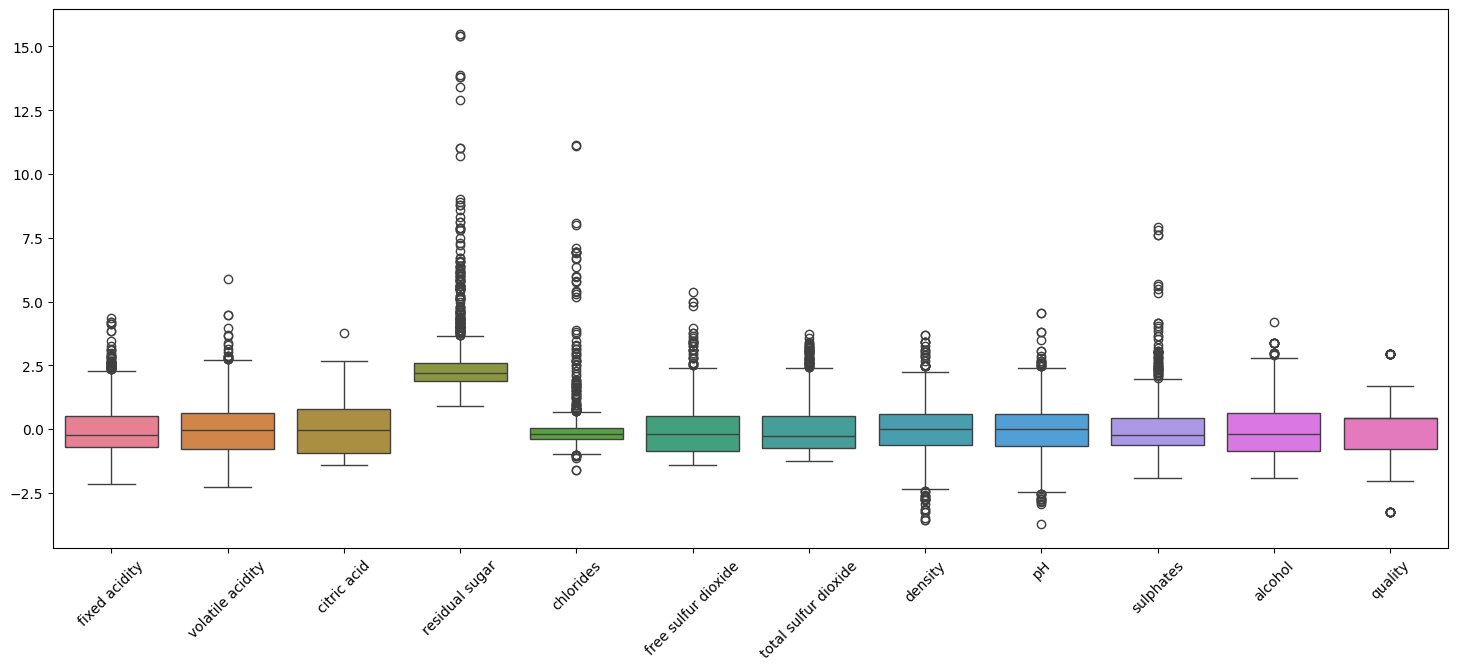

In [76]:
cols_2_zscore = df.keys().drop('residual sugar')
df[cols_2_zscore] = df[cols_2_zscore].apply(stats.zscore)

fig, ax = plt.subplots(1, figsize = (18, 7))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

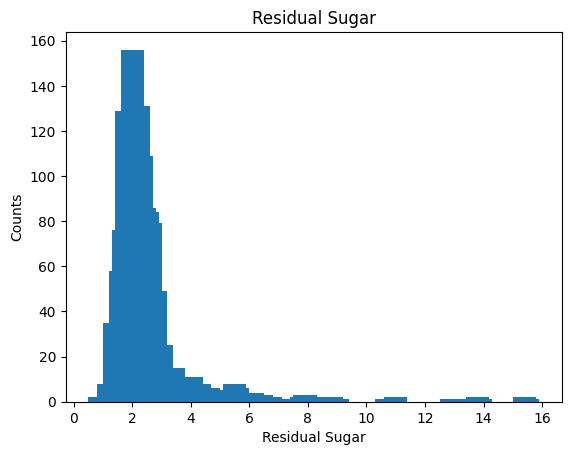

In [77]:
plt.bar(df['residual sugar'].value_counts().keys(), list(df['residual sugar'].value_counts()))
plt.xlabel('Residual Sugar')
plt.ylabel('Counts')
plt.title('Residual Sugar')
plt.show()

It's skewed, let's log transform it

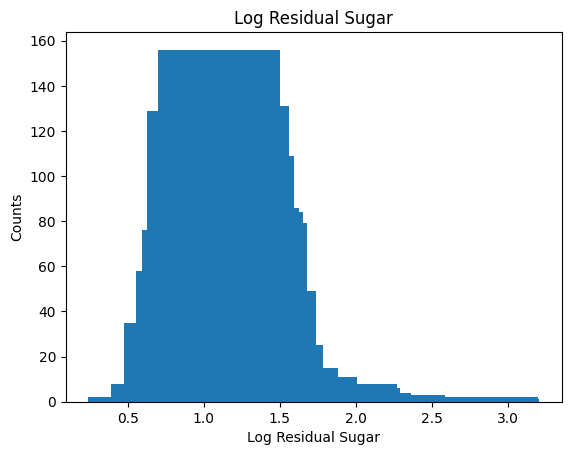

In [78]:
df['log residual sugar'] = np.log1p(df['residual sugar'])
plt.bar(df['log residual sugar'].value_counts().keys(), list(df['log residual sugar'].value_counts()))
plt.xlabel('Log Residual Sugar')
plt.title('Log Residual Sugar')
plt.ylabel('Counts')
plt.show()

Prep data

In [79]:
data = torch.tensor(df[cols_2_zscore].values).float()
labels = torch.tensor(df['log residual sugar'].values).float()

data.shape, labels.shape

(torch.Size([1597, 11]), torch.Size([1597]))

# Train Test Split

In [80]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(data, labels, train_size = .8)

train_dataset = TensorDataset(X_train_, y_train_)
test_dataset = TensorDataset(X_test_, y_test_)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = X_train_.shape[0])

# Model Arch

In [81]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(11, 16)

    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 64)

    self.output = nn.Linear(64, 1)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)

    x = self.output(x)

    return x

# Model Setup

In [82]:
def ModelSetup():
  ann = Model()
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3)
  return ann, loss_fn, optimizer

# Model Train

In [83]:
def ModelTrain(epochs):
  ann, loss_fn, optimizer = ModelSetup()

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  train_MAEs = torch.zeros(epochs)
  test_MAEs = torch.zeros(epochs)
  train_RMSEs = torch.zeros(epochs)
  test_RMSEs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_MAEs = torch.zeros(len(train_dataloader))
    batch_RMSEs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):
      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      batch_MAE = torch.mean(
          torch.abs(
              batch_y_hat - y_train
              )
      )
      batch_MAEs[batch] = batch_MAE

      batch_RMSE = torch.sqrt(
          torch.mean(
              torch.square(
                  batch_y_hat - y_train
              )
          )
      )
      batch_RMSEs[batch] = batch_RMSE

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()


    train_losses[epoch] = torch.mean(batch_losses)
    train_MAEs[epoch] = torch.mean(batch_MAEs)
    train_RMSEs[epoch] = torch.mean(batch_RMSEs)

    ann.eval()

    X_test, y_test = next(iter(test_dataloader))
    test_y_hat = ann(X_test)

    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss

    test_MAE = torch.mean(
        torch.abs(
            test_y_hat - y_test
            )
        )
    test_MAEs[epoch] = test_MAE

    test_RMSE = torch.sqrt(
        torch.mean(
            torch.square(
                test_y_hat - y_test
            )
        )
    )
    test_RMSEs[epoch] = test_RMSE

    if epoch%10 == 0:
      print(f'Epoch: {epoch} | Train -> MAE: {train_MAEs[epoch]:2f} RMSE: {train_RMSEs[epoch]:2f} Loss: {train_losses[epoch]:2f} | Test -> MAE: {test_MAE:2f} RMSE: {test_RMSE:2f} Loss: {test_loss:2f}')

  return ann, train_losses, train_MAEs, train_RMSEs, test_losses, test_MAEs, test_RMSEs

In [84]:
ann, train_losses, train_MAEs, train_RMSEs, test_losses, test_MAEs, test_RMSEs = ModelTrain(epochs = 100)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([320])) that is different to the input size (torch.Size([320, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train -> MAE: 1.221308 RMSE: 1.249133 Loss: 1.563367 | Test -> MAE: 1.183195 RMSE: 1.215874 Loss: 1.478349
Epoch: 10 | Train -> MAE: 0.503420 RMSE: 0.566657 Loss: 0.325560 | Test -> MAE: 0.491454 RMSE: 0.566903 Loss: 0.321379
Epoch: 20 | Train -> MAE: 0.206428 RMSE: 0.313771 Loss: 0.100480 | Test -> MAE: 0.207605 RMSE: 0.328487 Loss: 0.107904
Epoch: 30 | Train -> MAE: 0.179904 RMSE: 0.274946 Loss: 0.078320 | Test -> MAE: 0.184513 RMSE: 0.292889 Loss: 0.085784
Epoch: 40 | Train -> MAE: 0.181667 RMSE: 0.267635 Loss: 0.075364 | Test -> MAE: 0.186763 RMSE: 0.288537 Loss: 0.083253
Epoch: 50 | Train -> MAE: 0.183932 RMSE: 0.270704 Loss: 0.076005 | Test -> MAE: 0.187270 RMSE: 0.287524 Loss: 0.082670
Epoch: 60 | Train -> MAE: 0.183146 RMSE: 0.267400 Loss: 0.074610 | Test -> MAE: 0.187229 RMSE: 0.286895 Loss: 0.082309
Epoch: 70 | Train -> MAE: 0.184156 RMSE: 0.269870 Loss: 0.076499 | Test -> MAE: 0.187066 RMSE: 0.286393 Loss: 0.082021
Epoch: 80 | Train -> MAE: 0.181881 RMSE: 0.265153

# Plots

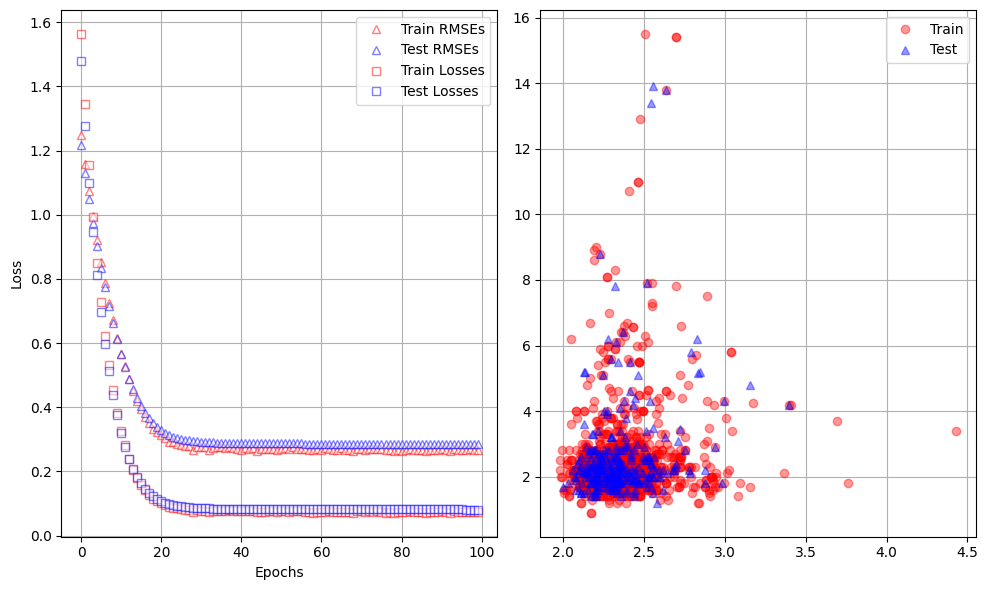

In [85]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

# ax[0].plot(train_MAEs.detach(), 'k^', markerfacecolor = 'w', label = 'Train MAEs', alpha = .5)
# ax[0].plot(test_MAEs.detach(), 'bs', markerfacecolor = 'w', label = 'Test MAEs', alpha = .5)
# ax[0].set_ylabel('MAE')

ax[0].plot(train_RMSEs.detach(), 'r^', markerfacecolor = 'w', label = 'Train RMSEs', alpha = .5)
ax[0].plot(test_RMSEs.detach(), 'b^', markerfacecolor = 'w', label = 'Test RMSEs', alpha = .5)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('RMSE')

ax[0].plot(train_losses.detach(), 'rs', markerfacecolor = 'w', label = 'Train Losses', alpha = .5)
ax[0].plot(test_losses.detach(), 'bs', markerfacecolor = 'w', label = 'Test Losses', alpha = .5)
ax[0].set_ylabel('Loss')


y_hat_train_log = ann(X_train_)
y_hat_train = torch.expm1(y_hat_train_log)
y_hat_test_log = ann(X_test_)
y_hat_test = torch.expm1(y_hat_test_log)

exp_y_train = torch.expm1(y_train_)
exp_y_test = torch.expm1(y_test_)

ax[1].plot(y_hat_train.detach(), exp_y_train, 'ro', alpha = 0.4, label = 'Train')
ax[1].plot(y_hat_test.detach(), exp_y_test, 'b^', alpha = 0.4, label = 'Test')

for i in range(2):
  ax[i].legend()
  ax[i].grid()

plt.tight_layout()
plt.show()

Model Predicts quite well, the thing here is that most of the values were distributed around value of 2, therefore model didn't learn to predict outliers well. However, values that were represented enough in the data are predicted well.

# Predict

In [86]:
rand_row = np.random.randint(df.shape[0])

ind_vars = df.columns.drop('residual sugar')
ind_vars = torch.tensor(df.loc[rand_row, ind_vars].values, dtype = torch.float)
ind_vars

tensor([-1.5619, -1.2189,  2.6221, -0.2871,  0.6854,  1.4404,  0.0100,  0.5096,
        -1.0523,  0.0746,  0.4535,  2.7014])

In [87]:
def random_row_pred():

  rand_row = np.random.randint(df.shape[0])

  y_true = df.loc[rand_row, 'residual sugar']

  ind_vars = df.columns.drop(['residual sugar', 'log residual sugar'])
  ind_vars = torch.tensor(df.loc[rand_row, ind_vars].values, dtype = torch.float)

  ann.eval()
  with torch.no_grad():
    y_pred_log = ann(ind_vars.unsqueeze(0)).squeeze(1)
    y_pred = torch.expm1(y_pred_log)

  return ind_vars, y_true, y_pred

In [88]:
ind_vars, y_true, y_pred = random_row_pred()
ind_vars, y_true, y_pred

(tensor([-0.7006,  0.8489, -1.0316, -0.2659,  0.0146,  0.1518,  0.0525,  0.4447,
         -0.8162, -0.8653, -0.7866]),
 np.float64(1.9),
 tensor([2.3428]))

# Plot Pred

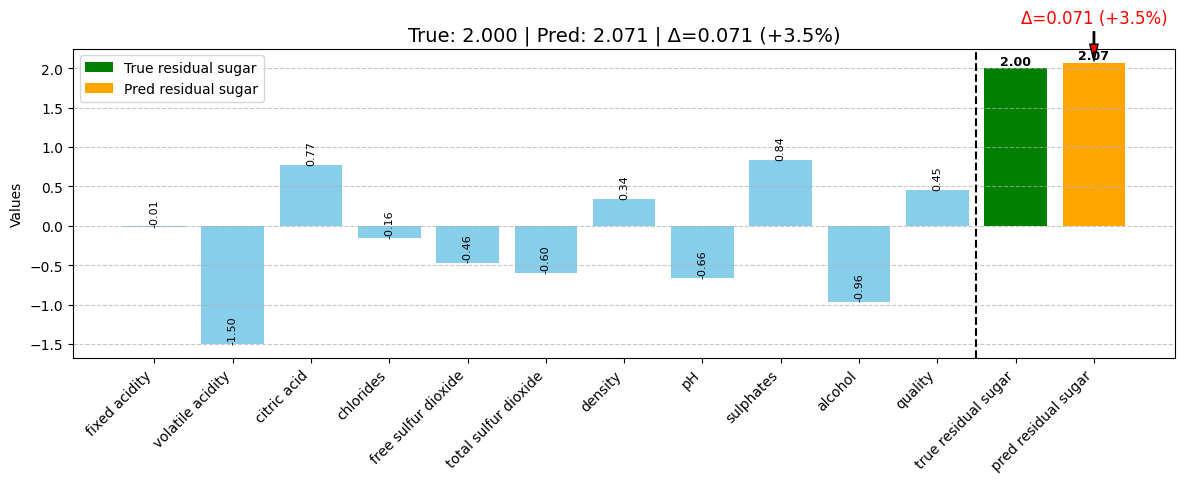

In [92]:
ind_vars, y_true, y_pred = random_row_pred()

# labels i values
labels = df.columns.drop(['residual sugar', 'log residual sugar']).tolist() + [
    'true residual sugar', 'pred residual sugar'
]
values = ind_vars.detach().cpu().numpy().tolist() + [y_true.item(), y_pred.item()]

fig, ax = plt.subplots(figsize=(12, 5))

# zwykłe featury
bars1 = ax.bar(labels[:-2], values[:-2], color='skyblue')

# true/pred jako osobne słupki
bar_true = ax.bar(labels[-2], values[-2], color='green', label="True residual sugar")
bar_pred = ax.bar(labels[-1], values[-1], color='orange', label="Pred residual sugar")

# linia przerywana oddzielająca featury od targetów
ax.axvline(x=len(labels)-2.5, color='black', linestyle='--')

# delta absolutna i procentowa
delta = values[-1] - values[-2]
delta_pct = (delta / values[-2]) * 100 if values[-2] != 0 else float('inf')

# adnotacja z Δ i Δ%
ax.annotate(
    f"Δ={delta:.3f} ({delta_pct:+.1f}%)",
    xy=(len(labels)-1, max(values[-1], values[-2])),
    xytext=(len(labels)-1, max(values[-1], values[-2]) + 0.5),
    ha='center',
    color='red',
    fontsize=12,
    arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=6)
)

# wartości nad barami
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}",
            ha='center', va='bottom', fontsize=8, rotation=90)

for bar in bar_true + bar_pred:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}",
            ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

# opis osi
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel("Values")

# tytuł z Δ%
ax.set_title(f"True: {values[-2]:.3f} | Pred: {values[-1]:.3f} | Δ={delta:.3f} ({delta_pct:+.1f}%)", fontsize=14)

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()